# Provasi Matteo (782922)

# Assignment 4

## Consegna
<br>
<font size=3>

Implementare uno script di classificazione basato sul fine tuning di feature neurali, a partire dalle istruzioni viste ad esercitazione.

Non è consentito l'uso dello stesso modello visto in laboratorio (ResNet).
Utilizzare lo stesso dataset scelto per l'assignment dell'esercitazione 5

In [0]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
import os
import tarfile
from sklearn.metrics import classification_report, confusion_matrix

from keras.applications import inception_v3
from keras.applications import resnet50
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image as kimage

In [1]:
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import optimizers

Using TensorFlow backend.


<font size=3>
  
  <b>!wget</b> è un comando esclusivo di Google Colab che permette di accedere a dei file data unurl.

In [2]:
!wget https://www.dropbox.com/s/rpjde5xeflnj7nz/Natural_Images.tar

--2019-07-16 13:25:00--  https://www.dropbox.com/s/rpjde5xeflnj7nz/Natural_Images.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rpjde5xeflnj7nz/Natural_Images.tar [following]
--2019-07-16 13:25:00--  https://www.dropbox.com/s/raw/rpjde5xeflnj7nz/Natural_Images.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc599dc1e55b554df4d3e017b0d6.dl.dropboxusercontent.com/cd/0/inline/AkyAJF6KyAuWPYatzXEhvl-gm7LoDzQUhEzUgeWyvwXDS859JhVNxnQDH9tCcfPex0vSBgehAghJlLucEQAQKUHPreh0rsFLAziLVgm-zT4vqg/file# [following]
--2019-07-16 13:25:01--  https://uc599dc1e55b554df4d3e017b0d6.dl.dropboxusercontent.com/cd/0/inline/AkyAJF6KyAuWPYatzXEhvl-gm7LoDzQUhEzUgeWyvwXDS859JhVNxnQDH9tCcfPex0vSBgehAghJlLucEQAQKUHPreh0rsFLAziLVgm-zT4vqg/fil

<font size=3>

Tramite la funzione ``tarfile.open`` si caricano i file presenti nella directory e nella successiva riga li si estraggono.

In [0]:
tar = tarfile.open('Natural_Images.tar')
tar.extractall()
tar.close()

In [ ]:
#!rm Natural_Images.tar

<font size=3>
    
I file da leggere sono dentro a due cartelle che a loro volta sono dentro un'altra cartella. Questa cartella è la directory di base da cui poi saranno caricate le immagini.

In [0]:
base_path = 'Natural_Images/'

<font size=3>

Con ``ImageDataGenerator`` si definisce il modello da utlizzare e con ``flow_from_directory`` si specificano le modalità con cui trattare le immagini caricate. Come spiegato nell'assignment precedente il modello richiede in ingresso delle immagini con dimensione $299x299$. La <b>batch_size</b> indica il numero di campioni che sono utilizzati per allenare la rete in uno step. La rete sarà costruita a partire da $32$ immagini e si continuerà seguendo campioni di questa grandezza <br>
Dato che si ha già a disposizione un test e un train set non è necessario specificare lo split a differenza degli altri assignment. Nel caso si avesse un unico insieme di immagini è possibile utilizzare il parametro <br>validation_split</b> in ``ImageDataGenerator`` per indicare quante immagini devono essere prese come train e quante come test. La stessa funzione viene creata per prendere le immagini del test set.

In [11]:
# Training set
train_datagen = kimage.ImageDataGenerator(preprocessing_function=inception_v3.preprocess_input)
train_generator = train_datagen.flow_from_directory(
        directory=base_path + 'Train',
        target_size=(299, 299),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=1
)

Found 4829 images belonging to 8 classes.


In [12]:
# Test set
test_datagen = kimage.ImageDataGenerator(preprocessing_function=inception_v3.preprocess_input)
test_generator = test_datagen.flow_from_directory(
        directory=base_path + 'Test',
        target_size=(299, 299),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False
)

Found 2070 images belonging to 8 classes.


<font size=3>

Si inizia con la creazione di una rete neurale InceptionV3 senza strati fully connected utilizzando un pooling medio.

In [0]:
nn = inception_v3.InceptionV3(include_top=False, weights='imagenet', pooling='avg')

<font size=3>

Con <b>layer.trainable = False</b> si indica che gli strati della rete non devono essere aggiornati durante il processo di learning in quanto si vuole appunto effettuare un fine-tuning. Vengono aggiunti alla rete due strati:
* Uno strato fully connected con $64$ neuroni
* Uno strato softmax con il numero di classi del target
<br></br>
Alla rete viene assegnato una funzione di ottimizzazione e come parametro di loss la <b>categorical_crossentropy</b> in quanto si è in un problema di multi-class in cui l'appartenenza ad una classe è esclusiva.

In [0]:
for layer in nn.layers:
    layer.trainable = False
    
x = nn.output
x = Dense(64, activation='relu')(x)
pred = Dense(8, activation='softmax')(x)

net = Model(inputs=nn.input, outputs=pred)
net.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

<font size=3>

Con la funzione fit_generator si passa alla rete il generatore che prende le immagini del train e procede con il fine-tuning dei parametri per un numero arbitrario di epoche. Il numero di step da effettuare per ogni epoca deve essere approssimativamente il rapporto $sample/batchsize$. <br>
Si effettua un addestramento con $10$ confrontando l'accuracy ad ogni passaggio per vedere quando da un epoca all'altra non ci sono più miglioramenti significativi di accuratezza.

In [22]:
net.fit_generator(train_generator, steps_per_epoch=151, epochs=10, verbose=1)

Epoch 1/10
151/151 [==============================] - 51s 340ms/step - loss: 0.2881 - acc: 0.9327
Epoch 2/10
151/151 [==============================] - 47s 314ms/step - loss: 0.0448 - acc: 0.9863
Epoch 3/10
151/151 [==============================] - 47s 314ms/step - loss: 0.0293 - acc: 0.9905
Epoch 4/10
151/151 [==============================] - 47s 313ms/step - loss: 0.0187 - acc: 0.9942
Epoch 5/10
151/151 [==============================] - 47s 313ms/step - loss: 0.0304 - acc: 0.9921
Epoch 6/10
151/151 [==============================] - 47s 313ms/step - loss: 0.0209 - acc: 0.9934
Epoch 7/10
151/151 [==============================] - 47s 313ms/step - loss: 0.0185 - acc: 0.9948
Epoch 8/10
151/151 [==============================] - 47s 313ms/step - loss: 0.0103 - acc: 0.9967
Epoch 9/10
151/151 [==============================] - 47s 313ms/step - loss: 0.0144 - acc: 0.9948
Epoch 10/10
151/151 [==============================] - 47s 312ms/step - loss: 0.0128 - acc: 0.9971


In [23]:
y_test = test_generator.classes


t1 = time()
y_dist = net.predict_generator(test_generator, steps=len(test_generator.filenames))
y_pred = np.argmax(y_dist, axis=1)
print("Predizione completata in %0.3f secondi" % (time() - t1))

Predizione completata in 81.224 secondi


In [24]:
# Report
target_names = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00       222
         car       1.00      1.00      1.00       274
         cat       0.99      1.00      0.99       273
         dog       1.00      0.98      0.99       209
      flower       1.00      0.99      0.99       275
       fruit       0.98      1.00      0.99       299
   motorbike       1.00      1.00      1.00       227
      person       1.00      1.00      1.00       291

    accuracy                           1.00      2070
   macro avg       1.00      0.99      1.00      2070
weighted avg       1.00      1.00      1.00      2070



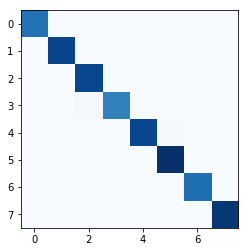

In [25]:
# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)

In [26]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[222   0   0   0   0   0   0   0]
 [  0 274   0   0   0   0   0   0]
 [  0   0 272   0   0   1   0   0]
 [  0   0   3 205   0   1   0   0]
 [  1   0   0   0 271   3   0   0]
 [  0   0   0   0   0 299   0   0]
 [  0   0   0   0   0   0 227   0]
 [  0   0   0   1   0   0   0 290]]


<font size=3>

La performance classificativa è simile a quella del modello del precedente assignment, le osservazioni classificare erroneamente sono $10$ con un'accuratezza complessiva di $0.9951$. La classe <i>dog</i> in questo caso non è la peggiore ma risulta essere <i>fruit</i>.

## Seconda rete

<font size=3>

Il modello ottenuto in precedenza con $10$ epoche raggiungeva l'accuratezza massima sul training proprio nell'ultimo passaggio. Questo risultato è stato ottenuto però dopo una serie di alti e bassi indicando che probabilmente il modello si è specializzato troppo sui dati.
Osservando i valori ottenuti in precedenza si nota come fino alla quarta epoca l'accuratezza aumenta sistematicamente per poi calare. <br>
Si costruisce quindi una seconda rete, uguale alla prima ma addestrata con $4$ epoche; i valori che si otterranno non saranno identici a quella precedente per via della costruzione del modello <b>InceptionV3</b>.

In [7]:
nn2 = inception_v3.InceptionV3(include_top=False, weights='imagenet', pooling='avg')

for layer in nn2.layers:
    layer.trainable = False
    
x = nn2.output
x = Dense(64, activation='relu')(x)
pred = Dense(8, activation='softmax')(x)

net2 = Model(inputs=nn2.input, outputs=pred)
net2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

W0716 13:26:11.369223 139893795407744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [13]:
net2.fit_generator(train_generator, steps_per_epoch=151, epochs=4, verbose=1)

W0716 13:26:45.330038 139893795407744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/4
151/151 [==============================] - 56s 368ms/step - loss: 0.2812 - acc: 0.9313
Epoch 2/4
151/151 [==============================] - 47s 312ms/step - loss: 0.0490 - acc: 0.9853
Epoch 3/4
151/151 [==============================] - 47s 312ms/step - loss: 0.0299 - acc: 0.9909
Epoch 4/4
151/151 [==============================] - 47s 312ms/step - loss: 0.0181 - acc: 0.9948


In [15]:
y_test = test_generator.classes


t1 = time()
y_dist = net2.predict_generator(test_generator, steps=len(test_generator.filenames))
y_pred = np.argmax(y_dist, axis=1)
print("Predizione completata in %0.3f secondi" % (time() - t1))


# Report
target_names = ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
print(classification_report(y_test, y_pred, target_names=target_names))

Predizione completata in 79.841 secondi
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00       222
         car       1.00      1.00      1.00       274
         cat       0.99      1.00      0.99       273
         dog       1.00      0.99      0.99       209
      flower       1.00      0.99      0.99       275
       fruit       0.99      1.00      1.00       299
   motorbike       1.00      1.00      1.00       227
      person       1.00      1.00      1.00       291

    accuracy                           1.00      2070
   macro avg       1.00      1.00      1.00      2070
weighted avg       1.00      1.00      1.00      2070



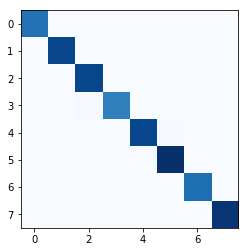

In [16]:
# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)

In [17]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[222   0   0   0   0   0   0   0]
 [  0 274   0   0   0   0   0   0]
 [  0   0 273   0   0   0   0   0]
 [  0   0   3 206   0   0   0   0]
 [  1   0   0   0 271   3   0   0]
 [  0   0   0   0   0 299   0   0]
 [  0   0   0   0   0   0 227   0]
 [  0   0   0   0   0   0   0 291]]


<font size=3>

L'accuratezza che si ottiene è la stessa identica a quella dell'assignment precedente con $7$ osservazioni classificate in maniera sbagliata. In questa rete le osservazioni sbagliate si concnetrano quasi esclusivamente nelle classi <i>cat</i> e ancora <i>fruit</i>. 